# Modelagem
Após terminar a Análise Exploratória de Dados e o Feature Engineering, feitos no arquivo [EDA.ipynb](EDA.ipynb), vamos iniciar o treinamento de nosso modelo. O objetivo do modelo é prever se uma reserva será cancelada.

Utilizaremos o algoritmo XGBoost, que é uma implementação otimizada de Gradient Boosting. O Gradient Boosting é um algoritmo de ensemble no qual treinamos classificadores de forma sequencial, em que cada classificador tenta corrigir os erros dos anteriores por meio da modalagem dos resíduos deixados por eles.

In [1]:
#carregando as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, f1_score, plot_roc_curve


#carregando os dados
df = pd.read_csv('hotels_model_data.csv')

#os meses de ArrivalDateMonth estãocomo string.
print(df.ArrivalDateMonth.unique())

#convertendo os meses para números (para não trabalhar com 12 dummies)
df.ArrivalDateMonth = df.ArrivalDateMonth.map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})

## Preprocessamento das features
Antes do treinamento, faremos um preprocessamento final das features. Vamos transformar as features categórias em dummies.

In [2]:
#convertendo a quantidade de Children para int (estão em float)
df.Children = df.Children.apply(lambda x: int(x))

In [3]:
#substituindo os 'espaços' por '_' nas categorias de DepositType
df.DepositType = df.DepositType.map({'No Deposit': 'No_Deposit', 'Non Refund': 'Non_Refund', 'Refundable': 'Refundable'})

In [4]:
#gerando as colunas dummies das features categóricas
df_model = pd.get_dummies(df, columns=['ArrivalDateMonth', 'Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'DepositType', 'CustomerType'])

In [5]:
#verificando as colunas existentes em nosso dataframe, após o preprocessamento
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78879 entries, 0 to 78878
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IsCanceled                     78879 non-null  int64  
 1   LeadTime                       78879 non-null  int64  
 2   ArrivalDateWeekNumber          78879 non-null  int64  
 3   ArrivalDateDayOfMonth          78879 non-null  int64  
 4   StaysInWeekendNights           78879 non-null  int64  
 5   StaysInWeekNights              78879 non-null  int64  
 6   Adults                         78879 non-null  int64  
 7   Children                       78879 non-null  int64  
 8   Babies                         78879 non-null  int64  
 9   IsRepeatedGuest                78879 non-null  int64  
 10  PreviousCancellations          78879 non-null  int64  
 11  PreviousBookingsNotCanceled    78879 non-null  int64  
 12  BookingChanges                 78879 non-null 

## Train Test Split
Nossos dados já estão no formato apropriado para serem inputados no modelo.

Antes do treinamento, separamos nosso conjunto de dados em conjunto de treinamento, validação e teste. Faremos um split de 60/20/20%, respectivamente.
O objetivo do conjunto de validação é escolher o melhor entre os modelos que treinaremos. Já o conjunto de teste será usado uma única vez, ao final do projeto, para estimar a performance que nosso modelo terá em produção.

Faremos um split estratificado. Ou seja, manteremos a mesma proporção de reservas canceladas em cada conjunto.

In [6]:
#train test split
from sklearn.model_selection import train_test_split

#separando a variável dependente e as variáveis independentes
y = df_model.IsCanceled
X = df_model.drop('IsCanceled', axis=1)

#separando o conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=101, stratify=y)

#separando os conjuntos de teste e validação
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=101, stratify=y_test)

#tamanho de cada conjunto:
print(f"Conjunto de treinamento: {X_train.shape[0]} exemplos")
print(f"Conjunto de validação: {X_val.shape[0]} exemplos")
print(f"Conjunto de teste: {X_test.shape[0]} exemplos")

Conjunto de treinamento: 47327 exemplos
Conjunto de validação: 15776 exemplos
Conjunto de teste: 15776 exemplos


## Benchmark model
Vamos treinar um modelo com os parâmetros default do XGBoost para termos uma base de performance.

Escolhemos usar a métrica da área sob a curva do ROC (auc). Isso nos dará o modelo que tem melhor trade-off entre a precisão e o recall de cancelamentos.

Usando nosos conjunto de validação, interromperemos o treinamento de novos previsores (árvores) quando não observarmos melhora de auc em 30 árvores seguidas.

In [261]:
#instanciando o modelo do xgboost para benchmark
model = XGBClassifier(n_estimators=1000)

#treinando o modelo de benchmark
model.fit(X_train, y_train, early_stopping_rounds=30, eval_set=[(X_val, y_val)], eval_metric='auc', verbose=0)

#fazendo previsões no conjunto de validação com o modelo de benchmark
predictions = model.predict(X_val)

#calculando e imprimindo as métricas do modelo de benchmark
accuracy = accuracy_score(y_val, predictions)
recall = recall_score(y_val, predictions)
precision = precision_score(y_val, predictions)
f1_scoree = f1_score(y_val, predictions)
print("Métricas do modelo de benchmark:")
print(f"AUC: {model.evals_result()['validation_0']['auc'][-1]}")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("f1_score: %.2f%%" % (f1_scoree * 100.0))

Métricas do modelo de benchmark:
AUC: 0.946865
Accuracy: 87.23%
Recall: 82.54%
Precision: 86.37%
f1_score: 84.41%


Entre as reservas que foram canceladas em nosso conjunto de validação, o modelo de benchmark conseguiu prever corretamente 82.54% delas (recall).

Mais abaixo, discutirei com profundidade o recall obtido pelo modelo, e tentarei otimizá-lo. Acredito que o recall tenha uma relevância grande para o projeto. Isso porque o recall mede o percentual de acertos do modelo nas reservas que são canceladas, de fato. E se o hotel sabe de antemão que uma reserva tem alta probabilidade de cancelamento, pode agir para evitar esse cancelamento (oferecendo algum benefício ao cliente, por exemplo). Isso tem um grande potencial de impacto no negócio, uma vez que, [como vimos](EDA.ipynb), 41% de todas as reservas são canceladas, em média.

## Refinando o modelo
Agora que já treinamos nosso modelo de benchmark, vamos procurar os valores dos hiperparâmetros do xgboost que otimizam nossa métrica de avaliação, o auc.

A implementação do Gradient Boosting do XGBoosting possui vários parâmetros de treinamento, como por exemplo o learning_rate (coeficiente do resultado encontrado por cada árvore para o cálculo da previsão final) e max_depth (número máximo de camadas de cada árvore, que restringe a quantidade de splits que cada árvore faz). Esses parâmetros não são treináveis, i.e., devem ser informados manualmente ao algoritmo antes que ele realize o treinamento que irá determinar as especificações do modelo que fará a previsão de novos exemplos. Por isso, eles são chamados de hiperparâmetros.

O processo de refinamento consiste em treinar diferentes modelos, que diferem pelos seus hiperparâmetros, e utilizar nosso conjunto de validação para verificar qual dos modelos faz a melhor previsão. Compararemos a qualidade dos modelos pela métrica do auc, conforme dito acima.

As duas formas mais comuns de se testar diferentes conjuntos de hiperparâmetros são o "grid search" e o "random search". No primeiro, definimos um conjunto discreto de valores candidatos para cada hiperparâmetro, e treinamos modelos com todas as combinações possíveis entre os diferentes hiperparâmetros. No segundo, definimos intervalos de valores candidatos para cada hiperparâmetro, e selecionamos aleatoriamente, dentro de cada intervalo, os valores que serão utilizados em cada modelo.

Uma terceira forma de fazer a busca por hiperparâmetros é o [Bayesian optimization](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a). Nesse método, também sorteamos aleatoriamente valores para os hiperparâmetros. Mas, ao contrário do random search, onde a distribuição de probabilidades entre os valores possíveis é uniforme, o Bayesian optimization utiliza iterativamente os resultados que vão sendo obtidos para explorar mais intensamente os intervalos de valores mais promissores, para cada hiperparâmetro. Assim, a cada novo modelo treinado, é atualizada a distribuição de probabilidade dos valores associados a cada hiperparâmetro. A implementação do Bayesian optimization que utilizaremos aqui é a do pacote [hyperopt](https://github.com/hyperopt/hyperopt).

Como o pacote [hyperopt](https://github.com/hyperopt/hyperopt) precisa de uma função para MINIMIZAR, vamos definí-la como 1 - auc. Assim, minimizando o auc, estamos maximizando o auc.

In [169]:
from hyperopt import STATUS_OK

#definindo a função que treina o modelo e calcula a métrica de avaliação
def objective(params):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""     
    
    #gerando o modelo
    model = XGBClassifier(
        n_estimators=1000,
        learning_rate = params['learning_rate'],
        gamma = params['gamma'],
        max_depth = params['max_depth'],
        min_child_weight = params['min_child_weight'],
        reg_lambda = params['reg_lambda'],
        reg_alpha = params['reg_alpha'],
    )
    
    #treinando o modelo
    model.fit(X_train, y_train, early_stopping_rounds=30, eval_set=[(X_val, y_val)], eval_metric='auc', verbose=0)
    
    #métrica de avaliação: 1 - ROC AUC
    loss = 1 - model.evals_result()['validation_0']['auc'][-1]
    
    # dicionário com o resultado
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [205]:
#Espaço de hiperparâmetros a ser explorado
from hyperopt import hp

space = {
#    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
#                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'gamma': hp.uniform('gamma', 0.0, 5.0),
    'max_depth': hp.randint('max_depth', 5, 20),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.08), np.log(10)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 2.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
}

In [253]:
#testando o espaço de hiperparâmetros: sorteando um conjunto aleatório de hiperparâmetros
from hyperopt.pyll.stochastic import sample

example = sample(space)
example

{'gamma': 2.1602457808326743,
 'learning_rate': 0.2802196181178618,
 'max_depth': array(16),
 'min_child_weight': 5.920776518774782,
 'reg_alpha': 1.289599111321481,
 'reg_lambda': 0.43225440411094906}

In [257]:
# Treinando os primeiros 50 modelos

# Algoritmo
from hyperopt import tpe
tpe_algorithm = tpe.suggest


# Objeto que registra o progresso
from hyperopt import Trials
bayes_trials = Trials()

# Função que faz a busca
from hyperopt import fmin

# Rodando a busca
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 50, trials = bayes_trials)

 99%|████████████████████████████████████████████▋| 121/122 [00:49<00:00,  2.44trial/s, best loss: 0.04821600000000004]


In [14]:
#salvando/retomando a busca do hyperopt

import pickle
#salvando a busca
#pickle.dump(bayes_trials, open("hyperopt_trials.p", "wb"))

#carregando a busca
bayes_trials = pickle.load(open("hyperopt_trials.p", "rb"))

#quantos trials já foram rodados?
print(f"número de modelos já treinados: {len(bayes_trials.losses())}")

número de modelos já treinados: 320


In [266]:
#reiniciando a busca

best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 320, trials = bayes_trials)

100%|█████████████████████████████████████████▊| 319/320 [1:31:44<00:17, 17.26s/trial, best loss: 0.047996999999999956]


É possível salvar o resultado parcial da busca e depois retomá-la, conforme fiz acima.

A busca retorna o conjunto de hiperparâmetros que otimiza a métrica de avaliação. Abaixo, treinamos o modelo com o melhor conjunto de hiperparâmetros.

In [15]:
#treinando o melhor modelo

params = bayes_trials.best_trial['result']['params']


model = XGBClassifier(
        n_estimators=1000,
        learning_rate = params['learning_rate'],
        gamma = params['gamma'],
        max_depth = params['max_depth'],
        min_child_weight = params['min_child_weight'],
        reg_lambda = params['reg_lambda'],
        reg_alpha = params['reg_alpha'],
    )

model.fit(X_train, y_train, early_stopping_rounds=30, eval_set=[(X_val, y_val)], eval_metric='auc', verbose=0)

#printando loss do melhor modelo
auc = 1 - model.evals_result()['validation_0']['auc'][-1]
print(f"auc do melhor modelo: {1-auc}")

auc do melhor modelo: 0.952003


A busca bayesiana permitiu que refinássemos os hiperparâmetros, aumentando o auc de 0.9469 (modelo de benchmark) para 0.9520.

Além disso, conforme vemos abaixo, nosso modelo refinado foi capaz de classificar corretamente 83.42% das reservas que foram canceladas em nosso conjunto de validação (recall), contra a marca de 82.54% do modelo de benchmark.

In [16]:
#fazendo previsões no conjunto de validação com o modelo refinado
predictions = model.predict(X_val)

#calculando e imprimindo as métricas do modelo refinado
accuracy = accuracy_score(y_val, predictions)
recall = recall_score(y_val, predictions)
precision = precision_score(y_val, predictions)
f1_scoree = f1_score(y_val, predictions)
print("Métricas do modelo refinado no conjunto de validação:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("f1_score: %.2f%%" % (f1_scoree * 100.0))

Métricas do modelo refinado no conjunto de validação:
Accuracy: 87.92%
Recall: 83.42%
Precision: 87.19%
f1_score: 85.26%


#### Avaliando overfitting
Vemos abaixo que nosso modelo alcançou um f1_score de 96.62% no conjunto de treinamento, contra 85.26% no conjunto de validação. Isso aponta que nosso modelo tem um certo grau de overfitting, uma vez que sua performance é consideravelmente melhor nos pontos em que foi treinado. 

Para minimizar o overfitting podemos otimizar certos hiperparâmetros do XGBoosting com que ainda não trabalhamos, como o subsample. Outra estratégia para combater o problema é aumentar o tamanho de nosso conjunto de treinamento. Para isso, uma possibilidade é fazermos k-fold validation, ao invés de usar um conjunto separado para validação.

Numa próxima etapa do projeto tentaremos minimizar esse overfitting. 

In [18]:
#fazendo previsões no conjunto de treinamento com o modelo refinado
predictions = model.predict(X_train)

#calculando e imprimindo as métricas do modelo refinado
accuracy = accuracy_score(y_train, predictions)
recall = recall_score(y_train, predictions)
precision = precision_score(y_train, predictions)
f1_scoree = f1_score(y_train, predictions)
print("Métricas do modelo refinado no conjunto de treinamento:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("f1_score: %.2f%%" % (f1_scoree * 100.0))

Métricas do modelo refinado no conjunto de treinamento:
Accuracy: 97.18%
Recall: 96.20%
Precision: 97.04%
f1_score: 96.62%


## Otimizando para o Recall
Conforme discutido acima, acredito que o recall tenha uma relevância grande para o projeto. Isso porque o recall mede o percentual de acertos do modelo nas reservas que são canceladas, de fato. E se o hotel sabe de antemão que uma reserva tem alta probabilidade de cancelamento, pode agir para evitar esse cancelamento (oferecendo algum benefício ao cliente, por exemplo). Isso tem um grande potencial de impacto no negócio, uma vez que, [como vimos](EDA.ipynb), 41% de todas as reservas são canceladas, em média.

Até agora, para que nosso modelo previsse que uma reserva seria cancelada, era necessário que a probabilidade de cancelamento calculada para essa reserva chegasse a 50%. Podemos otimizar o recall diminuindo esse threshold de probabilidade. Assim, por exemplo, uma reserva com 45% de probabilidade de cancelamento já seria prevista como cancelada por nosso modelo.

Temos um trade-off, no entanto. Ao diminuir esse threshold, estaremos cometendo, com mais frequência, o erro de classificar como canceladas reservas que, de fato, não seriam canceladas. O impacto desse erro para o negócio é que o hotel oferecerá, com maior frequência, algum tipo de vantagem para clientes que não iriam cancelar suas reservas.

Para avaliar o trade-off, plotaremos o precision e recall.

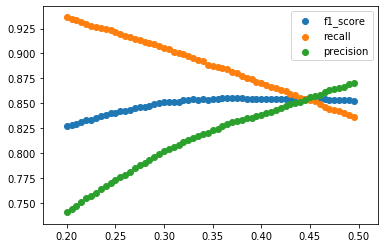

In [80]:
#fazendo as previsões da probabilidade de cancelamento no conjunto de validação
predictions_proba = model.predict_proba(X_val)

#colocando as probabilidades calculadas num dataframe
pred_df = pd.DataFrame(predictions_proba, columns=['0', '1'])
    
#candidatos a thresholds
thresholds_list = [i for i in np.arange(0.2, 0.5, 0.005)]
    
#dicionário para guardar os resultados
results = {'threshold': [], 'recall': [], 'precision': [], 'f1_scoree': []}

#calculando precision, recall e f1-score para diferentes thresholds e guardando o resultado num dicionário
for threshold in thresholds_list:
    #previsão para o threshold da vez
    predictions = pred_df['1'].apply(lambda x: 1 if x > threshold else 0)
    #calculando as métricas e guardando no dicionário de resultados
    results['threshold'].append(threshold)
    results['recall'].append(recall_score(y_val, predictions))
    results['precision'].append(precision_score(y_val, predictions))
    results['f1_scoree'].append(f1_score(y_val, predictions))
    
#plotando as métricas contra o threshold
plt.scatter(y=results['f1_scoree'], x=results['threshold'], label='f1_score')
plt.scatter(y=results['recall'], x=results['threshold'], label='recall')
plt.scatter(y=results['precision'], x=results['threshold'], label='precision')

plt.legend()
plt.show()

Como previsto, à medida que o recall aumenta, a precision diminui. Como estamos dando mais importância ao recall, conforme explicado acima, vou escolher o threshold de 0.25. Em outras palavras, toda vez que nosso modelo calcular que a probabilidade de uma reserva ser cancelada é maior que 25%, nossa previsão será de que aquela reserva será cancelada.

Como podemos ver abaixo, o threshold de 25% dá, no conjunto de validação, um recall de 92.12% e uma precision de 77.33%.

Isso significa que, sempre que uma reserva vai ser cancelada pelo cliente, nosso modelo consegue prever corretamente em 92.12% dos casos. Em contrapartida, de todas as vezes que nosso modelo diz que uma reserva será cancelada, ele acerta em 77.33% das vezes. Ou seja, em 22.66% das vezes que nosso modelo diz que uma reserva será cancelada, na verdade ela não é.

In [90]:
threshold = 0.25

pred_df["final_pred"] = pred_df['1'].apply(lambda x: 1 if x > threshold else 0)

#fazendo previsões no conjunto de validação com o modelo refinado
predictions = pred_df["final_pred"]

#calculando e imprimindo as métricas do modelo refinado
accuracy = accuracy_score(y_val, predictions)
recall = recall_score(y_val, predictions)
precision = precision_score(y_val, predictions)
f1_scoree = f1_score(y_val, predictions)
print("Métricas com threshold de 25% no conjunto de validação:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("f1_score: %.2f%%" % (f1_scoree * 100.0))

Métricas com threshold de 25% no conjunto de validação:
Accuracy: 49.84%
Recall: 49.55%
Precision: 41.69%
f1_score: 45.28%


## Estimando a acurácia do modelo em produção
Para estimar o desempenho do nosso modelo em produção, vamos utilizar o conjunto de teste. Perceba que essa é a primeira vez que utilizamos o conjunto de teste na modelagem. Isso garante que nenhum hiperparâmetro foi selecionado para otimizar o modelo para esse conjunto.

Os pontos que temos no conjunto de teste nunca foram vistos pelo modelo, de modo que seu desempenho nesse conjunto é uma medida mais acurada do desempenho que o modelo terá no mundo real, em produção.

Vemos abaixo que o modelo teve um desempenho no conjunto de teste muito próximo daquele observado no conjunto de validação. Isso significa que nosso modelo generaliza bem para pontos inéditos, e nos dá maior confiança de usá-lo em produção.

A estimativa final é que nosso consegue prever corretamente 92.03% das reservas que serão canceladas. Ao mesmo tempo, 22.56% das vezes que nosso modelo diz que uma reserva será cancelada, ele erra.

In [89]:
#test set

predictions_proba = model.predict_proba(X_test)

pred_df = pd.DataFrame(predictions_proba, columns=['0', '1'])

threshold = 0.25

pred_df["final_pred"] = pred_df['1'].apply(lambda x: 1 if x > threshold else 0)

#fazendo previsões no conjunto de validação com o modelo refinado
predictions = pred_df["final_pred"]

#calculando e imprimindo as métricas do modelo refinado
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1_scoree = f1_score(y_test, predictions)
print("Métricas no conjunto de teste:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("f1_score: %.2f%%" % (f1_scoree * 100.0))

Métricas no conjunto de teste:
Accuracy: 85.43%
Recall: 92.03%
Precision: 77.44%
f1_score: 84.11%


In [10]:
#salvando o modelo
from joblib import dump

dump(model, 'xgboost_model.joblib')

['xgboost_model.joblib']

In [19]:
#salvando o X_train
X_train.to_csv('X_train.csv', index=False)

y_train.to_csv('y_train.csv', index=False)